### Notebook principal pour le test du système

In [2]:
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
import kagglehub
import shutil
from tabulate import tabulate
import matplotlib.pyplot as plt
from pipeline_data_integration.data_integration import data_integration_pipeline, embedding_of_dataframe
from pipeline_recommendation.classical_recommendation import try_from_pickle, tfidf, embeded_similarity

#### Téléchargement des données

In [ ]:
if not os.path.exists("data"):
   os.makedirs("data")

path1 = kagglehub.dataset_download("balraj98/clothing-coparsing-dataset")
shutil.copytree(path1, "./data/clothing-coparsing-dataset")

path2 = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
shutil.copytree(path2, "./data/fashion-product-images-small")


Resuming download from 428867584 bytes (163747352 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/paramaggarwal/fashion-product-images-small?dataset_version_number=1 (428867584/592614936) bytes left.


100%|██████████| 565M/565M [00:06<00:00, 24.9MB/s]

Extracting files...


#### Pipeline d'intégration des données

Cette pipeline nous permet de charger les données et de les augmenter avec un LLM multimodal.
Elle opère différents traitement sur les données afin qu'elles soient utilisables par les systèmes de recommandations.
En production cette pipeline ne tournerait qu'une seule fois au déploiement de l'application puis lors de mises 
à jour ou d'ajout d'items dans la base de données.  
⚠️ Pour des raisons de démo nous allons charger artificiellement le resultat de cette pipeline dans la cellule suivante  
⚠️ Ne pas exécuter cette cellule car cela nous as pris 10h à exécuter sur une GTX3060

In [ ]:
# ⚠️ Ne pas exécuter cette cellule ⚠️
data_integration_pipeline()

In [22]:
# Pour la démo nous chargeons les dataframes depuis les checkpoints de l'étape précédente (pour une raison de temps)
df_outfits = pd.read_pickle("checkpoints/outfits_first_augmentation.pkl")
df_clothes = pd.read_pickle("checkpoints/clothes_second_augmentation_second_pass.pkl")

In [3]:
!ollama pull all-minilm
!ollama pull nomic-embed-text
!ollama pull mxbai-embed-large

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   0% ▕                ▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   1% ▕                ▏ 2.3 MB/274 MB                  pulling manif

Percentage of augmented rows : 100.0%
Exemple of row :
+------+------------+-----------------+--------------+---------------------------------+---------------------------------+-------------------------------------------------------+--------+
|      |   image_id | image_path      | label_type   | label_path                      | raw_label_path                  | caption                                               | type   |
|------+------------+-----------------+--------------+---------------------------------+---------------------------------+-------------------------------------------------------+--------|
| 1004 |       1005 | images/1005.jpg | image-level  | image_level_labels_txt/1005.txt | image_level_labels_mat/1005.mat | Walking the runway of life with confidence and style! | Casual |
+------+------------+-----------------+--------------+---------------------------------+---------------------------------+-------------------------------------------------------+--------+


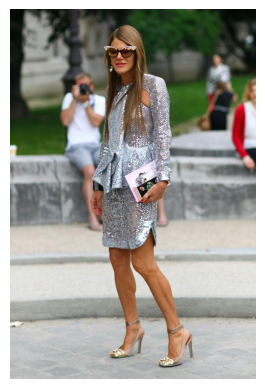

In [23]:
# Informations sur le dataframe de tenues
print(f"Percentage of augmented rows : {((len(df_outfits)-df_outfits.caption.isna().sum())/len(df_outfits))*100}%")
print(f"Exemple of row :")
print(tabulate(df_outfits.iloc[[0]], headers='keys', tablefmt='psql'))

img = np.asarray(Image.open('data/clothing-coparsing-dataset/images/1005.jpg'))
plt.axis('off')
plt.imshow(img)

In [24]:
# Informations sur le dataframe d'habit
print(f"Percentage of augmented rows : {((len(df_clothes)-df_clothes.caption.isna().sum())/len(df_clothes))*100}%")
print(f"Exemple of row :")
print(tabulate(df_clothes.iloc[[25]], headers='keys', tablefmt='psql'))

Percentage of augmented rows : 66.59941999747825%
Exemple of row :
+----+--------------+-------------+-----------------+----------------------------------------------------------+--------------+-------------+---------+
|    | class_name   |   outfit_id | image_path      | caption                                                  | baseColour   | category    | usage   |
|----+--------------+-------------+-----------------+----------------------------------------------------------+--------------+-------------+---------|
| 25 | bag          |        1007 | images/1008.jpg | Chic and stylish ensemble, perfect for a casual day out. | Multi        | Apparel Set | Casual  |
+----+--------------+-------------+-----------------+----------------------------------------------------------+--------------+-------------+---------+


#### Algorithme de recommandation classique

Ici, nous vous présentons notre pipeline de recommandation classique, pour le fil d'actualité. Celle-ci est disponible dans la fonction `run_recommendation_pipeline`, mais une méthode `try_from_pickle` a été créée afin de faciliter son exécution sur un utilisateur aléatoire. Elle retourne une liste de similarité cosine, pour tout les éléments du tableau d'habits.
Deux fonctions, `tfidf()` et `embeded_similarity(model)`, ont été créées, permettant ainsi d'exécuter cette pipeline en modifiant à notre guise l'algorithme à son coeur.

In [7]:
# Avec le tfidf
try_from_pickle("checkpoints/clothes_second_augmentation_second_pass.pkl", tfidf, one_hot=True)

[[np.float64(0.6670862527423284),
  np.float64(0.7145112130900811),
  np.float64(0.9050549864659576),
  np.float64(0.7503875533575042),
  np.float64(0.7143497491811148),
  np.float64(0.676366048798813),
  np.float64(0.6366124414757255),
  np.float64(0.7876756985427789),
  np.float64(0.8803511333054522),
  np.float64(0.7296981767561304),
  np.float64(0.7456709697529205),
  np.float64(0.3223910571410785),
  np.float64(0.5079059602527816),
  np.float64(0.6409933141075764),
  np.float64(0.5595489051069398),
  np.float64(0.3638810843883882),
  np.float64(0.9344498947196471),
  np.float64(0.4008598223719958),
  np.float64(0.5340731414966761),
  np.float64(0.7029228482181105),
  np.float64(0.5009575227656138),
  np.float64(0.7498014781912882),
  np.float64(0.37138654790641046),
  np.float64(0.5340731414966761),
  np.float64(0.3638810843883882),
  np.float64(0.49638246840272293),
  np.float64(0.9265784666451706),
  np.float64(0.9190418582013),
  np.float64(0.8960060143701574),
  np.float64(0.8

In [3]:
# Avec l'embedding via all-minilm
try_from_pickle("checkpoints/clothes_second_augmentation_second_pass.pkl", embeded_similarity, extra_ra_args={"model": "all-minilm"})

{'model': 'all-minilm'}


Embedding with all-minilm: 100%|██████████| 5282/5282 [01:30<00:00, 58.43it/s]


[[np.float64(0.12657338627720416),
  np.float64(0.12239890284038402),
  np.float64(0.13055889744252158),
  np.float64(0.10119629196770097),
  np.float64(0.12344380394145071),
  np.float64(0.20001530105389753),
  np.float64(0.09002373680789766),
  np.float64(0.09089461616026207),
  np.float64(0.23071651030220441),
  np.float64(0.14619352157473275),
  np.float64(0.11187966342904576),
  np.float64(0.07851039925478842),
  np.float64(0.12075329808481616),
  np.float64(0.17531120243700715),
  np.float64(0.0707707920322086),
  np.float64(0.06749353660616075),
  np.float64(0.1838968329649494),
  np.float64(0.08356533271724709),
  np.float64(0.043070993728011264),
  np.float64(0.14473303110513536),
  np.float64(0.09039475706701772),
  np.float64(0.1142516754095041),
  np.float64(0.09089504941957993),
  np.float64(0.043070993728011264),
  np.float64(0.06749353660616075),
  np.float64(0.06024418320944758),
  np.float64(0.22342612784395466),
  np.float64(0.09448500732554954),
  np.float64(0.110022

In [4]:
# Avec l'embedding via nomic-embed-text
try_from_pickle("checkpoints/clothes_second_augmentation_second_pass.pkl", embeded_similarity, extra_ra_args={"model": "nomic-embed-text"})

{'model': 'nomic-embed-text'}


Embedding with nomic-embed-text:   0%|          | 0/5282 [00:00<?, ?it/s]

Embedding with nomic-embed-text: 100%|██████████| 5282/5282 [02:01<00:00, 43.62it/s]


[[np.float64(0.07555540685633944),
  np.float64(0.08405420156150945),
  np.float64(0.1350273704649677),
  np.float64(0.10259759281468872),
  np.float64(0.07060629196847601),
  np.float64(0.12074094164004823),
  np.float64(0.0696900772547362),
  np.float64(0.13440383020484759),
  np.float64(0.142058672442391),
  np.float64(0.09952776833149712),
  np.float64(0.06680227168367714),
  np.float64(0.04716773869278135),
  np.float64(0.0625085322639164),
  np.float64(0.0844662906502942),
  np.float64(0.05313767016696713),
  np.float64(0.06578779138518043),
  np.float64(0.12796991234885668),
  np.float64(0.07390813636727711),
  np.float64(0.04309349425266584),
  np.float64(0.09838418327866916),
  np.float64(0.08120183688909521),
  np.float64(0.07541589946006144),
  np.float64(0.05760213585095986),
  np.float64(0.04309349425266584),
  np.float64(0.06578779138518043),
  np.float64(0.07183434039434122),
  np.float64(0.1226799320143872),
  np.float64(0.11111797093088072),
  np.float64(0.111701903929

In [5]:
# Avec l'embedding via mxbai-embed-large
try_from_pickle("checkpoints/clothes_second_augmentation_second_pass.pkl", embeded_similarity, extra_ra_args={"model": "mxbai-embed-large"})

{'model': 'mxbai-embed-large'}


Embedding with mxbai-embed-large: 100%|██████████| 5282/5282 [03:48<00:00, 23.12it/s]


[[np.float64(0.12470100454635658),
  np.float64(0.08840496838301115),
  np.float64(0.10597865632366965),
  np.float64(0.114604491612734),
  np.float64(0.0789473630715628),
  np.float64(0.16305096211765602),
  np.float64(0.08850973919485772),
  np.float64(0.1130236406795817),
  np.float64(0.1227313098018733),
  np.float64(0.08030988707068887),
  np.float64(0.06873375433431461),
  np.float64(0.07508894037235259),
  np.float64(0.07793314634091852),
  np.float64(0.06818711512398967),
  np.float64(0.05683432629213758),
  np.float64(0.06798887594264569),
  np.float64(0.11743775875651952),
  np.float64(0.06940410110420214),
  np.float64(0.06156879678594629),
  np.float64(0.10245074018889178),
  np.float64(0.08013510142685865),
  np.float64(0.12068124189837437),
  np.float64(0.06396843491360404),
  np.float64(0.06156879678594629),
  np.float64(0.06798887594264569),
  np.float64(0.09027560838556004),
  np.float64(0.1350487752336662),
  np.float64(0.10414150649782572),
  np.float64(0.12932529015

#### RAG / génération d'outfit cohérente en fonction d'une query utilisateur

In [2]:
from pipeline_recommendation.rag_recommendation import load_RAG, call_RAG

In [ ]:
# Génération des embeddings pour les vêtements tirés des tenues
embedding_model_names = ['all-minilm']
for mname in embedding_model_names:
    dataset = pd.read_pickle("checkpoints/clothes_second_augmentation_second_pass.pkl")
    embedding_of_dataframe(
        dataset, 
        f"checkpoints/embedding_clothes_{mname}.npy",
        mname
    )

In [5]:
# Génération des embeddings pour les vêtements utilisateurs
embedding_model_names = ['all-minilm']
if not os.path.exists("checkpoints/user_embedding_clothes_all-minilm_1.npy") or not os.path.exists("checkpoints/user_embedding_clothes_all-minilm_2.npy"):
    for mname in embedding_model_names:
        dataset = pd.read_csv("data/fashion-product-images-small/styles_fixed.csv")
        embedding_of_dataframe(
            dataset, 
            f"checkpoints/user_embedding_clothes_{mname}.npy",
            mname
        )
else:
    # transform user embedding chunks to user embeddings
    chunk_1 = np.load("checkpoints/user_embedding_clothes_all-minilm_1.npy", allow_pickle=True)
    chunk_2 = np.load("checkpoints/user_embedding_clothes_all-minilm_2.npy", allow_pickle=True)
    embeddings = np.concatenate((chunk_1, chunk_2))
    np.save("checkpoints/user_embedding_clothes_all-minilm.npy", np.array(embeddings))

In [15]:
# Test du rag
question = "A summer outfit with a red dress for a special occasion"
clothes_df, embedding, user_clothes_df, user_clothes_embedding = load_RAG(
    dataset_path='checkpoints/clothes_second_augmentation_second_pass.pkl',
    embedding_path="checkpoints/embedding_clothes_all-minilm.npy",
    user_clothes_dataset_path='data/fashion-product-images-small/styles_fixed.csv',
    user_clothes_embedding_path='checkpoints/user_embedding_clothes_all-minilm.npy'
)

ms_chunks, response = call_RAG(
    question, 
    embedding, 
    user_clothes_embedding, 
    clothes_df, 
    user_clothes_df, 
    'all-minilm'
)

Loading embeddings from checkpoints/embedding_clothes_all-minilm.npy...
Loading embeddings from checkpoints/user_embedding_clothes_all-minilm.npy...



Absolutely! Since it’s a special summer occasion, let's keep the look vibrant and stylish. A red dress is perfect for adding that pop of color to your outfit while staying on trend.

### Key Elements:

1. **Red Dress**: The centerpiece of this outfit is a bright red dress. It’s timeless yet celebratory, making it ideal for any special event. Red can evoke excitement and joy, which fits well with a festive summer occasion.
   
2. **Black Sandals or Heels**: To complement the bold red color, opt for black sandals or heels. This creates a striking contrast that keeps the outfit polished without overpowering the dress.

3. **Accessories**:
   - **Red Sunglasses**: Adding red sunglasses ties together your color scheme beautifully and adds an element of fun to your outfit.
   - **Black Wallet/Clutch**: A simple black clutch or wallet can hold

In [ ]:
def generate_outfit_image(chunks, clothes_df):
    images = []
    
    for subchunk in chunks:
        if not subchunk:
            continue
        score, item = subchunk[0]
        item_id = item['id']
        
        row = clothes_df.loc[clothes_df['id'] == item_id]
        if row.empty:
            continue
        
        image_path = f"data/fashion-product-images-small/images/{item_id}.jpg"
        try:
            img = Image.open(image_path).convert("RGBA")
            images.append(img)
        except Exception as e:
            print(f"Error opening image {image_path}: {e}")
    
    if not images:
        raise ValueError("No valid images found to combine.")
    
    columns = 2
    rows = math.ceil(len(images) / columns)
    cell_width, cell_height = 300, 300

    out_width = columns * cell_width
    out_height = rows * cell_height
    combined_img = Image.new("RGBA", (out_width, out_height), (255, 255, 255, 0))
    
    for i, img in enumerate(images):
        resized = img.resize((cell_width, cell_height))
        x_offset = (i % columns) * cell_width
        y_offset = (i // columns) * cell_height
        combined_img.paste(resized, (x_offset, y_offset))
    
    img = np.asarray(combined_img)
    plt.axis('off')
    plt.imshow(img)

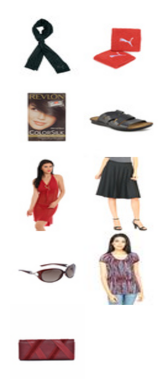

In [20]:
generate_outfit_image(ms_chunks, user_clothes_df)